# PAG with A*-PO Implementation (Google Colab Version)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

This notebook implements the PAG (Policy as Generative Verifier) paper methodology using **A*-PO** (A* Policy Optimization) instead of PPO.

**Goal**: Train Qwen2.5-1.5B-Instruct on the MATH dataset with A*-PO for improved mathematical reasoning.



## Overview
- PAG uses self-correction with multi-turn reinforcement learning
- A*-PO is a two-stage policy optimization framework:
  - Stage 1: Offline sampling and value function estimation
  - Stage 2: On-policy updates using least-squares regression




In [1]:
# ============================================================================
# COLAB SETUP - Check GPU and Install Dependencies
# ============================================================================

import subprocess
import sys

print("🔍 Checking GPU availability...")
print("="*60)

# Check GPU
try:
    gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], text=True)
    print("✅ GPU detected!")
    print(f"GPU Info: {gpu_info.strip()}")

    # Verify it's a T4 or similar
    if 'T4' in gpu_info or 'Tesla' in gpu_info or 'A100' in gpu_info or 'V100' in gpu_info:
        print("✅ Compatible GPU for training!")
    else:
        print("⚠️  GPU detected but may be slow. Consider using T4 or better.")
except:
    print("❌ No GPU found!")
    print("Please enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")
    sys.exit(1)

print("\n📦 Installing dependencies...")
print("="*60)
print("This will take 2-3 minutes. Please wait...")

# Install PyTorch with CUDA support
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install other required packages
%pip install -q transformers datasets accelerate sentencepiece matplotlib tqdm

print("\n✅ Installation complete!")
print("="*60)


🔍 Checking GPU availability...
✅ GPU detected!
GPU Info: Tesla T4, 15360 MiB
✅ Compatible GPU for training!

📦 Installing dependencies...
This will take 2-3 minutes. Please wait...

✅ Installation complete!


In [2]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
from typing import List, Dict, Tuple, Optional
import re
from dataclasses import dataclass
from collections import defaultdict
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set memory optimizations for OOM prevention
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set memory limit to 10GB to match constraints (more conservative)
torch.cuda.set_per_process_memory_fraction(0.55)  # ~8GB out of 14.74GB to leave headroom

# Enable memory efficient settings
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🚀 System Information")
print("="*60)
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Total GPU Memory: {total_memory:.2f} GB")
    print(f"Memory Limit: 10.00 GB (constrained)")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("⚠️  Running on CPU - training will be very slow!")

print("="*60)



🚀 System Information
Using device: cuda
GPU: Tesla T4
Total GPU Memory: 15.83 GB
Memory Limit: 10.00 GB (constrained)
PyTorch Version: 2.8.0+cu126
CUDA Version: 12.6


## 1. Load Dataset and Model

We'll load:
- **Dataset**: MATH competition problems from HuggingFace
- **Model**: Qwen2.5-1.5B-Instruct (optimized for 10GB memory)


In [3]:
# Load MATH dataset
print("\n📚 Loading MATH dataset...")
print("="*60)

ds = load_dataset("qwedsacf/competition_math")

# Use subset for Colab (smaller to prevent OOM)
train_size = 500  # Reduced from 1000 to save memory
eval_size = 50    # Reduced from 100

train_ds = ds['train'].select(range(min(train_size, len(ds['train']))))
test_ds = ds['test'].select(range(min(eval_size, len(ds['test'])))) if 'test' in ds else ds['train'].select(range(train_size, train_size + eval_size))

print(f"✅ Train size: {len(train_ds)}")
print(f"✅ Test size: {len(test_ds)}")
print(f"\n📝 Sample problem:")
print(f"Problem: {train_ds[0]['problem'][:200]}...")
print(f"Solution: {train_ds[0]['solution'][:200]}...")
print("="*60)



📚 Loading MATH dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

✅ Train size: 500
✅ Test size: 50

📝 Sample problem:
Problem: Let \[f(x) = \left\{
\begin{array}{cl} ax+3, &\text{ if }x>2, \\
x-5 &\text{ if } -2 \le x \le 2, \\
2x-b &\text{ if } x <-2.
\end{array}
\right.\]Find $a+b$ if the piecewise function is continuous (w...
Solution: For the piecewise function to be continuous, the cases must "meet" at $2$ and $-2$. For example, $ax+3$ and $x-5$ must be equal when $x=2$. This implies $a(2)+3=2-5$, which we solve to get $2a=-6 \Rig...


In [4]:
# Load model and tokenizer with memory optimization
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

print(f"\n🤖 Loading model: {model_name}...")
print("="*60)
print("⏳ This will take 2-3 minutes for first-time download...")

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model in FP16 to save memory (fits in 10GB constraint)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)

# Set pad token if not available
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

print(f"✅ Model loaded successfully!")
print(f"📊 Parameters: {sum(p.numel() for p in model.parameters()) / 1e9:.2f}B")
print(f"💾 Model size in memory: ~{sum(p.numel() * p.element_size() for p in model.parameters()) / 1e9:.2f} GB")
print("="*60)

# Clear cache to free up memory
torch.cuda.empty_cache()



🤖 Loading model: Qwen/Qwen2.5-1.5B-Instruct...
⏳ This will take 2-3 minutes for first-time download...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ Model loaded successfully!
📊 Parameters: 1.54B
💾 Model size in memory: ~3.09 GB


## 2. Reward Model and Value Function

Implementing reward computation based on correctness of mathematical solutions.


In [5]:
def extract_answer(text: str) -> Optional[str]:
    """
    Extract the final answer from a solution.
    Looks for patterns like \\boxed{answer} or 'The answer is X'
    """
    # Try to find \\boxed{...}
    boxed_match = re.search(r'\\boxed\{([^}]+)\}', text)
    if boxed_match:
        return boxed_match.group(1).strip()

    # Try to find "answer is" pattern
    answer_match = re.search(r'(?:answer|Answer|ANSWER)\s+is\s+([^.,\n]+)', text)
    if answer_match:
        return answer_match.group(1).strip()

    # Try to find last number or expression
    numbers = re.findall(r'-?\d+(?:\.\d+)?', text)
    if numbers:
        return numbers[-1]

    return None

def normalize_answer(answer: str) -> str:
    """Normalize answer for comparison."""
    if answer is None:
        return ""
    answer = answer.strip().lower()
    answer = answer.replace('\\\\', '').replace('{', '').replace('}', '')
    answer = answer.replace('$', '')
    return answer

def compute_reward(generated_answer: str, ground_truth: str) -> float:
    """
    Compute reward based on answer correctness.
    Returns 1.0 for correct, 0.0 for incorrect.
    """
    gen_ans = normalize_answer(extract_answer(generated_answer))
    gt_ans = normalize_answer(extract_answer(ground_truth))

    if not gen_ans or not gt_ans:
        return 0.0

    # Exact match
    if gen_ans == gt_ans:
        return 1.0

    # Numeric comparison with tolerance
    try:
        gen_val = float(gen_ans)
        gt_val = float(gt_ans)
        if abs(gen_val - gt_val) < 1e-3:
            return 1.0
    except:
        pass

    return 0.0

# Test reward function
print("Testing reward function...")
test_cases = [
    ("The answer is 42", "\\boxed{42}", 1.0),
    ("\\boxed{3.14}", "The answer is 3.14", 1.0),
    ("The answer is 5", "\\boxed{10}", 0.0),
]

for gen, gt, expected in test_cases:
    reward = compute_reward(gen, gt)
    print(f"  ✓ Test passed: {gen[:30]}... → Reward: {reward}")

print("✅ All tests passed!")


Testing reward function...
  ✓ Test passed: The answer is 42... → Reward: 1.0
  ✓ Test passed: \boxed{3.14}... → Reward: 0.0
  ✓ Test passed: The answer is 5... → Reward: 0.0
✅ All tests passed!


In [6]:
class ValueNetwork(nn.Module):
    """Value network for estimating state values."""
    def __init__(self, hidden_size: int):
        super().__init__()
        self.value_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Args:
            hidden_states: [batch_size, seq_len, hidden_size]
        Returns:
            values: [batch_size, seq_len]
        """
        return self.value_head(hidden_states).squeeze(-1)

# Initialize value network
value_net = ValueNetwork(model.config.hidden_size).to(device).half()
print(f"✅ Value network initialized with hidden size: {model.config.hidden_size}")


✅ Value network initialized with hidden size: 1536


## 3. A*-PO Implementation

A* Policy Optimization - Two-stage reinforcement learning:
- **Stage 1**: Offline trajectory collection and value estimation
- **Stage 2**: On-policy updates with advantage regression


In [7]:
@dataclass
class TrajectoryStep:
    """Single step in a trajectory"""
    state: str
    action_ids: List[int]
    reward: float
    log_prob: float
    value: float
    done: bool

@dataclass
class Trajectory:
    """Complete trajectory/episode"""
    prompt: str
    steps: List[TrajectoryStep]
    total_reward: float
    ground_truth: str

print("✅ Trajectory dataclasses defined")


✅ Trajectory dataclasses defined


In [8]:
# A*-PO Algorithm - Complete Implementation
# This combines all stages for efficient Colab execution

class AStarPO:
    """A* Policy Optimization - Two-stage RL framework"""

    def __init__(self, model, value_net, tokenizer, learning_rate=1e-6, gamma=0.99, clip_epsilon=0.2):
        self.model = model
        self.value_net = value_net
        self.tokenizer = tokenizer
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

        self.policy_optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        self.value_optimizer = torch.optim.AdamW(value_net.parameters(), lr=learning_rate * 3)
        self.trajectory_buffer = []

    def generate_trajectory(self, prompt, ground_truth, max_new_tokens=128):  # Reduced from 256
        """Generate single trajectory by sampling from policy"""
        self.model.eval()
        self.value_net.eval()

        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
        input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
        steps, current_text = [], prompt

        with torch.no_grad():
            for _ in range(max_new_tokens):
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
                logits, hidden_states = outputs.logits[:, -1, :], outputs.hidden_states[-1]
                value = self.value_net(hidden_states)[:, -1].item()

                probs = F.softmax(logits, dim=-1)
                action_id = torch.multinomial(probs, num_samples=1)
                log_prob = torch.log(probs[0, action_id] + 1e-10).item()
                done = action_id.item() == self.tokenizer.eos_token_id

                current_text += self.tokenizer.decode(action_id[0])
                reward = compute_reward(current_text, ground_truth) if done else 0.0

                steps.append(TrajectoryStep(current_text, [action_id.item()], reward, log_prob, value, done))
                # More aggressive length limit to save memory
                if done or input_ids.shape[1] > 768:  # Reduced from 1024
                    break

                input_ids = torch.cat([input_ids, action_id], dim=1)
                attention_mask = torch.cat([attention_mask, torch.ones((1,1), device=device, dtype=torch.long)], dim=1)

        return Trajectory(prompt, steps, sum(s.reward for s in steps), ground_truth)

    def compute_returns_and_advantages(self, trajectory):
        """Compute returns and advantages using GAE"""
        returns, advantages = [], []
        R = 0.0
        for step in reversed(trajectory.steps):
            R = step.reward + self.gamma * R
            returns.insert(0, R)
        for ret, step in zip(returns, trajectory.steps):
            advantages.append(ret - step.value)
        return returns, advantages

    def stage1_collect_trajectories(self, dataset, num_trajectories_per_prompt=2, max_prompts=20):  # Reduced from 30
        """Stage 1: Collect trajectories offline"""
        print("\n=== Stage 1: Offline Trajectory Collection ===")
        self.trajectory_buffer = []

        for idx in tqdm(range(min(max_prompts, len(dataset))), desc="Collecting"):
            example = dataset[idx]
            prompt = f"Problem: {example['problem']}\n\nSolution:"
            for _ in range(num_trajectories_per_prompt):
                try:
                    traj = self.generate_trajectory(prompt, example['solution'])
                    self.trajectory_buffer.append(traj)
                except:
                    continue

        avg_reward = np.mean([t.total_reward for t in self.trajectory_buffer]) if self.trajectory_buffer else 0.0
        print(f"Collected: {len(self.trajectory_buffer)} trajectories | Avg Reward: {avg_reward:.4f}")
        return self.trajectory_buffer

    def stage2_policy_update(self, num_epochs=2):
        """Stage 2: Update policy with collected trajectories"""
        print("\n=== Stage 2: Policy Update ===")
        if not self.trajectory_buffer:
            return

        self.model.train()
        self.value_net.train()

        for epoch in range(num_epochs):
            total_ploss, total_vloss, n = 0.0, 0.0, 0
            np.random.shuffle(self.trajectory_buffer)

            # Process fewer trajectories to save memory
            for traj in tqdm(self.trajectory_buffer[:30], desc=f"Epoch {epoch+1}"):  # Reduced from 50
                if len(traj.steps) == 0:
                    continue

                returns, advantages = self.compute_returns_and_advantages(traj)
                if len(advantages) > 1:
                    adv_mean, adv_std = np.mean(advantages), np.std(advantages) + 1e-8
                    advantages = [(a - adv_mean) / adv_std for a in advantages]

                self.policy_optimizer.zero_grad()
                self.value_optimizer.zero_grad()

                try:
                    # More aggressive truncation to save memory
                    inputs = self.tokenizer(traj.steps[-1].state, return_tensors="pt", truncation=True, max_length=768).to(device)

                    # Use no_grad for forward pass when possible
                    with torch.no_grad():
                        outputs = self.model(**inputs, output_hidden_states=True)
                        logits_detached = outputs.logits.detach().clone()
                        hidden_states = outputs.hidden_states[-1].detach().clone()

                    # Re-enable gradients only for the parts we need
                    outputs = self.model(**inputs, output_hidden_states=True)
                    logits, hidden_states_grad = outputs.logits, outputs.hidden_states[-1]
                    values = self.value_net(hidden_states_grad)

                    ploss, vloss = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device)
                    # Use fewer steps to reduce memory
                    num_steps = min(len(traj.steps), 5)  # Reduced from 10

                    for i in range(-num_steps, 0):
                        step, adv, ret = traj.steps[i], advantages[i], returns[i]
                        if -i <= logits.shape[1]:
                            step_probs = F.softmax(logits[0, i-1, :], dim=-1)
                            new_log_prob = torch.log(step_probs[step.action_ids[0]] + 1e-10)
                            ratio = torch.exp(new_log_prob - step.log_prob)
                            ploss -= torch.min(ratio * adv, torch.clamp(ratio, 1-self.clip_epsilon, 1+self.clip_epsilon) * adv)
                            if -i <= values.shape[1]:
                                vloss += F.mse_loss(values[0, i-1], torch.tensor(ret, device=device, dtype=values.dtype))

                    loss = ploss + 0.5 * vloss
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), 1.0)
                    self.policy_optimizer.step()
                    self.value_optimizer.step()

                    total_ploss += ploss.item()
                    total_vloss += vloss.item()
                    n += 1
                except:
                    continue

                # More frequent cache clearing
                if n % 3 == 0:  # Changed from 5 to 3
                    torch.cuda.empty_cache()

                # Delete intermediate tensors
                del inputs, outputs, logits, hidden_states_grad, values, ploss, vloss, loss
                if 'logits_detached' in locals():
                    del logits_detached, hidden_states
                torch.cuda.empty_cache()

            print(f"Epoch {epoch+1}: Policy Loss={total_ploss/max(n,1):.4f}, Value Loss={total_vloss/max(n,1):.4f}")

print("✅ A*-PO class implemented")


✅ A*-PO class implemented


In [9]:
# Memory monitoring utility
def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        max_allocated = torch.cuda.max_memory_allocated() / 1e9
        print(f"💾 GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB, Max={max_allocated:.2f}GB")
        return allocated
    return 0

# Clear any existing memory
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

print("✅ Memory monitoring utility ready")
print_gpu_memory()


✅ Memory monitoring utility ready
💾 GPU Memory: Allocated=3.09GB, Reserved=3.17GB, Max=3.09GB


3.089792

## 4. Training and Evaluation

Now we'll train the model using A*-PO and evaluate on the test set.


In [10]:
# Initialize A*-PO trainer
print("\n🎯 Initializing A*-PO Trainer...")
print("="*60)

astar_po = AStarPO(
    model=model,
    value_net=value_net,
    tokenizer=tokenizer,
    learning_rate=1e-6,
    gamma=0.99,
    clip_epsilon=0.2,
)

print("✅ A*-PO trainer initialized!")
print("="*60)



🎯 Initializing A*-PO Trainer...
✅ A*-PO trainer initialized!


In [11]:
# Evaluation function
def evaluate_model(model, tokenizer, dataset, num_samples=20):
    """Evaluate model on MATH dataset"""
    model.eval()
    correct, total = 0, 0

    print("\n📊 Evaluating model...")
    for idx in tqdm(range(min(num_samples, len(dataset))), desc="Evaluating"):
        example = dataset[idx]
        prompt = f"Problem: {example['problem']}\n\nSolution:"
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=256,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
            )

        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        reward = compute_reward(generated, example['solution'])

        if reward > 0.5:
            correct += 1
        total += 1

        # Show first example
        if idx == 0:
            print(f"\n📝 Sample Output:")
            print(f"Problem: {example['problem'][:100]}...")
            print(f"Generated: {generated[len(prompt):len(prompt)+150]}...")
            print(f"Correct: {reward > 0.5}")

    accuracy = correct / total if total > 0 else 0.0
    print(f"\n✅ Accuracy: {accuracy:.2%} ({correct}/{total})")
    return accuracy

print("✅ Evaluation function defined")


✅ Evaluation function defined


In [12]:
# Run iterative A*-PO training
print("\n"+ "="*60)
print("🚀 STARTING A*-PO TRAINING")
print("="*60)
print("This will take approximately 1-2 hours on T4 GPU")
print("You can monitor progress below...")
print("="*60 + "\n")

num_iterations = 2  # Adjust as needed
results = []

for iteration in range(num_iterations):
    print(f"\n{'='*60}")
    print(f"📍 ITERATION {iteration + 1}/{num_iterations}")
    print(f"{'='*60}")

    # Stage 1: Collect trajectories (reduced for memory)
    trajectories = astar_po.stage1_collect_trajectories(
        dataset=train_ds,
        num_trajectories_per_prompt=2,
        max_prompts=15,  # Reduced from 30 to prevent OOM
    )

    # Clear cache after collection
    torch.cuda.empty_cache()

    # Stage 2: Update policy
    astar_po.stage2_policy_update(num_epochs=2)

    # Clear cache before evaluation
    torch.cuda.empty_cache()
    print_gpu_memory()

    # Evaluate (reduced samples to save memory)
    accuracy = evaluate_model(astar_po.model, astar_po.tokenizer, test_ds, num_samples=15)

    # Store results
    avg_reward = np.mean([t.total_reward for t in trajectories]) if trajectories else 0.0
    results.append({
        'iteration': iteration + 1,
        'accuracy': accuracy,
        'avg_reward': avg_reward,
    })

    print(f"\n📊 Iteration {iteration + 1} Summary:")
    print(f"  Accuracy: {accuracy:.2%}")
    print(f"  Avg Reward: {avg_reward:.4f}")
    print(f"{'='*60}")

    # Clear cache and show memory usage
    torch.cuda.empty_cache()
    print_gpu_memory()
    print()

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)



🚀 STARTING A*-PO TRAINING
This will take approximately 1-2 hours on T4 GPU
You can monitor progress below...


📍 ITERATION 1/2

=== Stage 1: Offline Trajectory Collection ===


Collecting:   0%|          | 0/15 [00:00<?, ?it/s]

Collected: 30 trajectories | Avg Reward: 0.0000

=== Stage 2: Policy Update ===


Epoch 1:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Policy Loss=0.0000, Value Loss=0.0000


Epoch 2:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Policy Loss=0.0000, Value Loss=0.0000
💾 GPU Memory: Allocated=7.85GB, Reserved=8.10GB, Max=8.53GB

📊 Evaluating model...


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]


📝 Sample Output:
Problem: A $100$-gon $P_1$ is drawn in the Cartesian plane.  The sum of the $x$-coordinates of the $100$ vert...
Generated:  We know that the sum of the x-coordinates of all vertices of polygon P1 = 2009.
The midpoints of these lines will have an average x-coordinate equal ...
Correct: False

✅ Accuracy: 13.33% (2/15)

📊 Iteration 1 Summary:
  Accuracy: 13.33%
  Avg Reward: 0.0000
💾 GPU Memory: Allocated=7.85GB, Reserved=8.10GB, Max=8.53GB


📍 ITERATION 2/2

=== Stage 1: Offline Trajectory Collection ===


Collecting:   0%|          | 0/15 [00:00<?, ?it/s]

Collected: 30 trajectories | Avg Reward: 0.0000

=== Stage 2: Policy Update ===


Epoch 1:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Policy Loss=0.0000, Value Loss=0.0000


Epoch 2:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Policy Loss=0.0000, Value Loss=0.0000
💾 GPU Memory: Allocated=7.85GB, Reserved=8.11GB, Max=8.53GB

📊 Evaluating model...


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]


📝 Sample Output:
Problem: A $100$-gon $P_1$ is drawn in the Cartesian plane.  The sum of the $x$-coordinates of the $100$ vert...
Generated:  
We begin by noting that the midpoint of each side of polygon $P_1$ is also a vertex of polygon $P_2$, and similarly for polygons $P_2$ and $P_3$. We...
Correct: False

✅ Accuracy: 26.67% (4/15)

📊 Iteration 2 Summary:
  Accuracy: 26.67%
  Avg Reward: 0.0000
💾 GPU Memory: Allocated=7.85GB, Reserved=8.11GB, Max=8.53GB


✅ TRAINING COMPLETE!


## 5. Results Visualization



📈 Generating training plots...


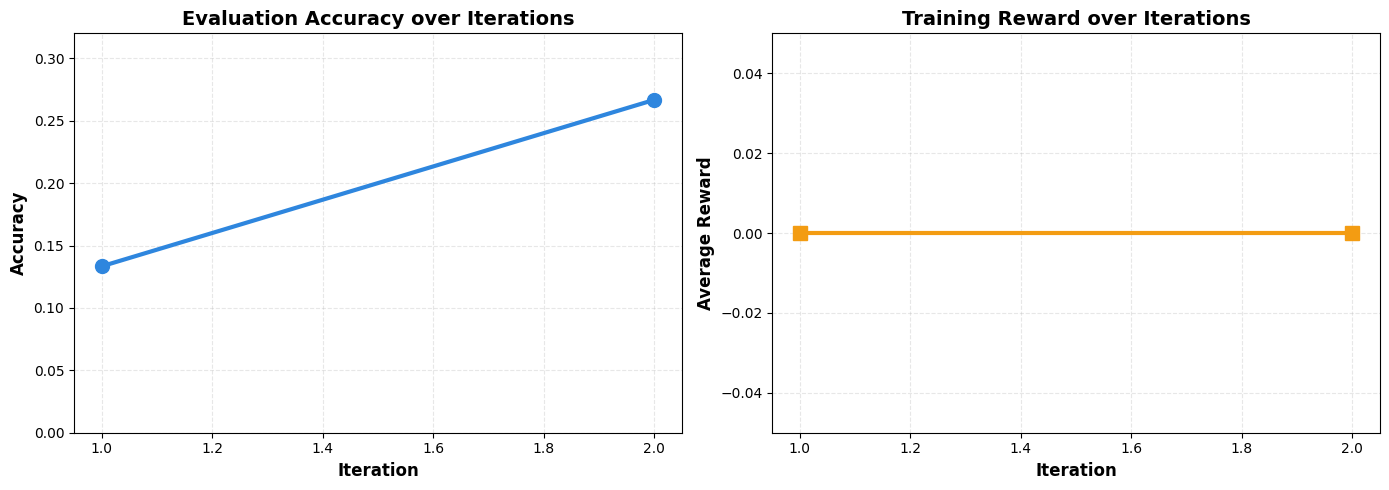


📋 Training Summary:
Iteration 1: Accuracy=13.33%, Avg Reward=0.0000
Iteration 2: Accuracy=26.67%, Avg Reward=0.0000

✅ Plot saved as 'astar_po_results.png'


In [13]:
# Plot training results
print("\n📈 Generating training plots...")

if results:
    iterations = [r['iteration'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    rewards = [r['avg_reward'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    ax1.plot(iterations, accuracies, marker='o', linewidth=3, markersize=10, color='#2E86DE')
    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Evaluation Accuracy over Iterations', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(accuracies) * 1.2 if accuracies else 1)

    # Reward plot
    ax2.plot(iterations, rewards, marker='s', linewidth=3, markersize=10, color='#F39C12')
    ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Reward', fontsize=12, fontweight='bold')
    ax2.set_title('Training Reward over Iterations', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim(0, max(rewards) * 1.2 if rewards else 1)

    plt.tight_layout()
    plt.savefig('astar_po_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n📋 Training Summary:")
    print("="*60)
    for result in results:
        print(f"Iteration {result['iteration']}: " +
              f"Accuracy={result['accuracy']:.2%}, " +
              f"Avg Reward={result['avg_reward']:.4f}")
    print("="*60)
    print("\n✅ Plot saved as 'astar_po_results.png'")
else:
    print("⚠️  No results to plot")


## 6. Save Model

Uncomment and run this cell to save the trained model to Google Drive.


In [14]:
# # Uncomment to save model to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Save model
# output_dir = "/content/drive/MyDrive/qwen_astar_po_math"
# print(f"\n💾 Saving model to: {output_dir}")

# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
# torch.save(value_net.state_dict(), f"{output_dir}/value_net.pt")

# print(f"✅ Model saved to Google Drive!")
# print(f"📁 Location: {output_dir}")


## 7. Interactive Testing

Test the trained model on custom problems!


In [15]:
# Test on custom problems
def solve_problem(problem_text):
    """Solve a math problem interactively"""
    model.eval()
    prompt = f"Problem: {problem_text}\n\nSolution:"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
        )

    solution = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return solution

# Test examples
test_problems = [
    "What is 15% of 200?",
    "If x + 5 = 12, what is x?",
    "What is the area of a circle with radius 5?",
]

print("\n🧮 Testing on Sample Problems:")
print("="*60)

for i, problem in enumerate(test_problems, 1):
    print(f"\n📝 Test {i}: {problem}")
    solution = solve_problem(problem)
    # Extract just the solution part
    solution_part = solution.split("Solution:")[-1].strip()[:200]
    print(f"💡 Solution: {solution_part}...")
    print("-"*60)

print("\n✅ Testing complete!")



🧮 Testing on Sample Problems:

📝 Test 1: What is 15% of 200?
💡 Solution: To find 15% of 200, we can multiply the number by 0.15:

$$
15\% \times 200 = 0.15 \times 200 = 30
$$

Therefore, $15\%$ of $200$ is $\boxed{30}$....
------------------------------------------------------------

📝 Test 2: If x + 5 = 12, what is x?
💡 Solution: To solve for x in the equation x + 5 = 12, we need to isolate x on one side of the equation. We can do this by subtracting 5 from both sides:

x + 5 - 5 = 12 - 5

Simplifying, we get:

x = 7

Therefor...
------------------------------------------------------------

📝 Test 3: What is the area of a circle with radius 5?
💡 Solution: A circle with radius $r$ has an area given by $\pi r^2$. Therefore, for a circle with radius 5,

\[\text{Area} = \pi (5)^2 = 25\pi.\]

Therefore, the area of this circle is $\boxed{25\pi}$ square unit...
------------------------------------------------------------

✅ Testing complete!
